# Data Science Interview Challenge


# 1 Contents<a id='1'></a>
1. [Contents](#1)
2. [Imports](#2)
3. [Part 1](#3)
    - [3.1 Load Data](#3.1)
    - [3.2 EDA](#3.2)
    - [3.3 Visualizations](#3.3)
    - [3.4 Conclusions](#3.4)
4. [Experiment Metrics & Design](#4)
5. [Predictive Modeling](#5)
    - [5.1 Cleaning, EDA, Visualizations](#5.1)
        - [5.1a Cleaning](#5.1a)
        - [5.1b EDA](#5.1b)
        - [5.1c Modeling](#5.1c)
6. [Recommendations](#6)(#6)


# 2 Imports <a id='2'></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from matplotlib.dates import MonthLocator, DateFormatter
import datetime as dt
from datetime import timedelta
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.tseries.offsets import DateOffset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from scipy.stats import uniform
import xgboost as xgb
import shap

# 3 Part 1 <a id='3'></a>
Instructions: The attached logins.json file contains (simulated) timestamps of user logins in a particular
geographic location. Aggregate these login counts based on 15minute
time intervals, and
visualize and describe the resulting time series of login counts in ways that best characterize the
underlying patterns of the demand. Please report/illustrate important features of the demand,
such as daily cycles. If there are data quality issues, please report them.

## 3.1 Load Data <a id='3.1'></a>

In [2]:
data = pd.read_json(r"C:\Users\leann\OneDrive\Desktop\SPRINGBOARD\interview prep\ultimate_challenge\logins.json")

## 3.2 EDA <a id='3.2'></a>

In [3]:
# Inspect data

data.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


Above I can see that I have one column, 'login_time', and there are 93143 rows of non-null data in datetime64 format.

In [5]:
# Set index to be the login time

data.set_index('login_time', inplace=True)

In [6]:
# Add a 'count' column so that I can aggregate log-in counts in 15 minute time intervals.

data['count'] = 1

# Now aggregate the log-in counts into 15 minute intervals
data_15min = data.resample('15T').sum()

data_15min.head()

,count
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


In [7]:
# Count number of 15 minute intervals:
num_rows = len(data_15min)
print('Total number of 15 minute intervals: ',num_rows)

Total number of 15 minute intervals:  9788


### 3.3 Visualizations <a id='3.3'></a>

First, I will do a plot of the login counts over time to see what I'm working with:

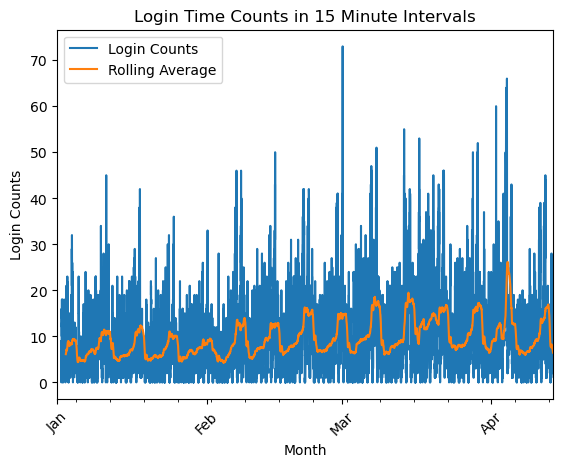

In [8]:
# Determine unique months
unique_months = data_15min.index.to_period('M').unique().to_timestamp()
month_labels = [month.strftime('%b') for month in unique_months]

# Plot the data in 15 min intervals
data_15min['count'].plot()

# Plot the rolling average
data_15min['count'].rolling(window=96).mean().plot()

plt.title('Login Time Counts in 15 Minute Intervals')
plt.xlabel('Month')
plt.ylabel('Login Counts')
plt.legend(['Login Counts', 'Rolling Average'])

# Set the x-ticks to the first of each month
plt.xticks(ticks=unique_months, labels=month_labels, rotation=45)

plt.show();

There is definitely a regular, repeating pattern here and it looks to be weekly. The login rates are also generally increasing over time. 

Next, I will look at seasonality.

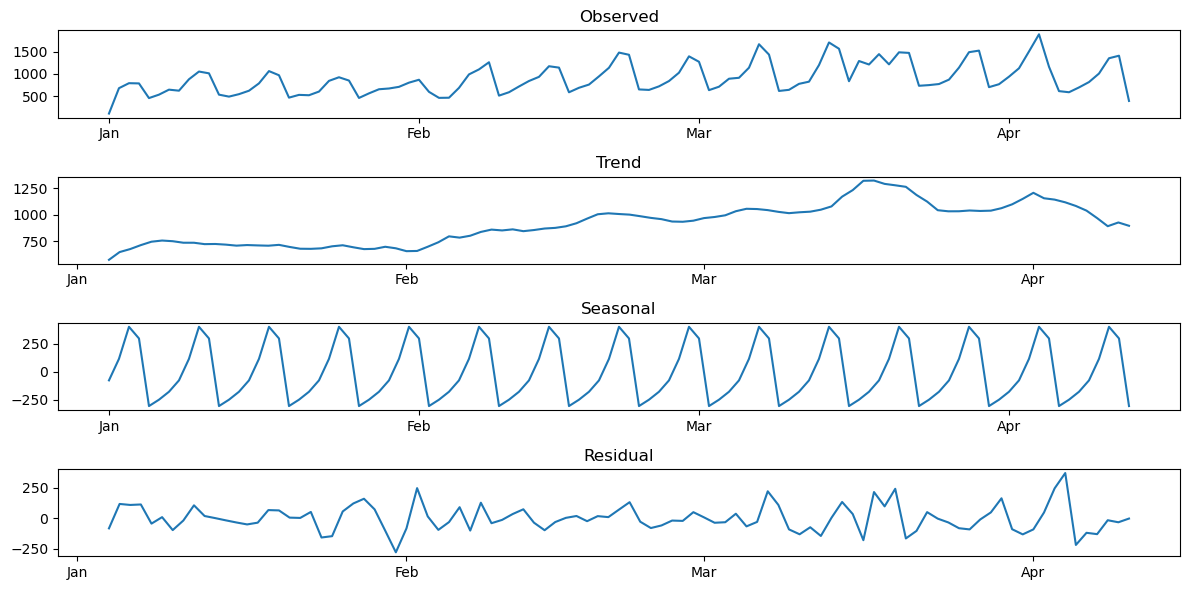

In [9]:
# Decompose the data to observe seasonal trends

# Aggregate the data into daily logins
daily_data = data['count'].resample('D').sum()

# Seasonal decomposition:
result = seasonal_decompose(daily_data, model='additive')

# Set up plot
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(12,6))

# Extract decomposed components
components = [result.observed, result.trend, result.seasonal, result.resid]
titles = ['Observed', 'Trend', 'Seasonal', 'Residual']

# Set up locators and formatters for the x axis
months = MonthLocator()
months_format = DateFormatter('%b')

# Plot
for ax, component, title in zip(axes,components,titles):
    ax.plot(component)
    ax.set_title(title)
    ax.xaxis.set_major_locator(months)
    ax.xaxis.set_major_formatter(months_format)
    
plt.tight_layout()
plt.show();

In the above decomposition, I see:
* There is a weekly seasonality in the data, and it looks like the login patterns are related to the days of the week as the pattern repeats roughly weekly.
* The 'Trend' plot shows that the logins gradually increase until mid-March, and then they start to go down.
* Although there is variation in the 'Residuals' plot, I do not see any alarming patterns. 

Next, I would like to look further into the weekly seasonality, and see if I can find regular troughs/peaks in particular days of the week. NOTE: The timestamps say that the year is 1970, which cannot be true given that the data is about logins. The year is a placeholder, so it's impossible to know the absolute day of the week. The code block below assigns days of the week, but they should be interpreted in a relative manner to the other days, not as the true day.

In [10]:
daily_data.head()

login_time
1970-01-01    112
1970-01-02    681
1970-01-03    793
1970-01-04    788
1970-01-05    459
Freq: D, Name: count, dtype: int64

In [11]:
# Identify local peaks
peaks = daily_data[(daily_data.shift(1) < daily_data) & 
                   (daily_data.shift(-1) < daily_data)]

# Identify local troughs
troughs = daily_data[(daily_data.shift(1) > daily_data) & 
                     (daily_data.shift(-1) > daily_data)]

# Extract day names for peaks and troughs
peak_days = peaks.index.day_name()

trough_days = troughs.index.day_name()

# Print the frequency of peak and trough days
peak_day_counts = peak_days.value_counts()
print('Peak Day Counts: ')
print(peak_day_counts)
print('')

trough_day_counts = trough_days.value_counts()
print('Trough Day Counts: ')
print(trough_day_counts)


Peak Day Counts: 
login_time
Saturday     11
Sunday        4
Tuesday       2
Wednesday     1
Thursday      1
Name: count, dtype: int64

Trough Day Counts: 
login_time
Monday       10
Tuesday       4
Wednesday     2
Thursday      1
Friday        1
Name: count, dtype: int64


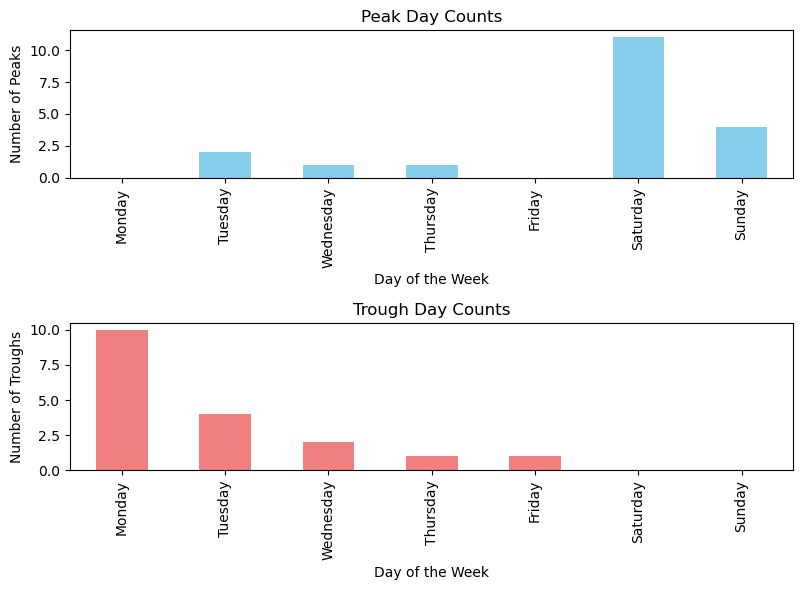

In [12]:
# Look at bar plots of the above information:

# Define the correct order of the days of the week
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Create a DataFrame with zeros for all days of the week & update w/ counts
all_days = pd.DataFrame(index=days_order, columns=['Peaks', 'Troughs'])
all_days['Peaks'] = 0
all_days['Troughs'] = 0

all_days['Peaks'].update(peak_day_counts)
all_days['Troughs'].update(trough_day_counts)

fig, axes = plt.subplots(2, 1, figsize=(8, 6))

# Plot peak day counts for all days
all_days['Peaks'].plot(kind='bar', ax=axes[0], color='skyblue')
axes[0].set_title('Peak Day Counts')
axes[0].set_xlabel('Day of the Week')
axes[0].set_ylabel('Number of Peaks')

# Plot trough day counts for all days
all_days['Troughs'].plot(kind='bar', ax=axes[1], color='lightcoral')
axes[1].set_title('Trough Day Counts')
axes[1].set_xlabel('Day of the Week')
axes[1].set_ylabel('Number of Troughs')

# Show the plot
plt.tight_layout()
plt.show()



Keeping in mind that we do not know the true day of the week, there is a fairly regular repeating pattern. The most popular login day is Saturday, followed by Sunday, and the woest number of logins are weekdays, particularly Mondays. 

Next, I will look at the login patterns within a given 24 hour period.

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


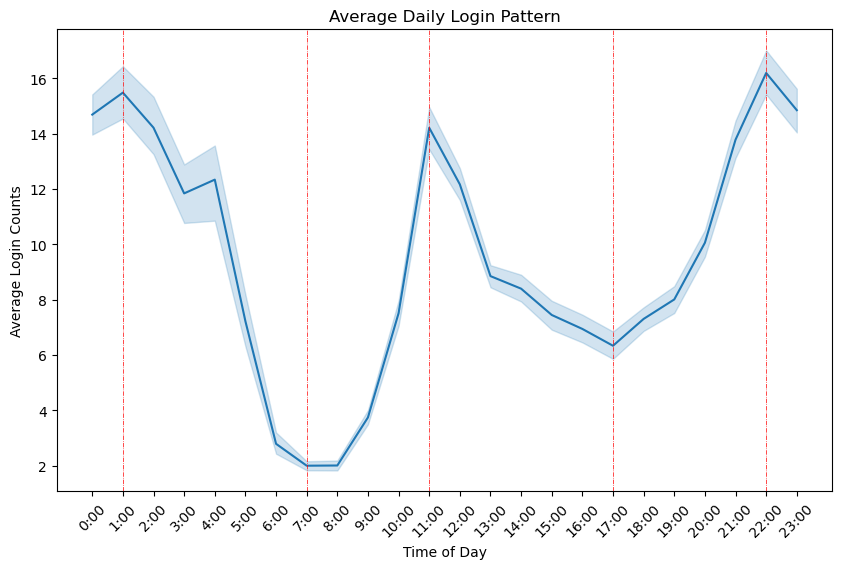

In [13]:
# Including vertical lines to more easily read where the max and min points are

data_15min['time_of_day'] = data_15min.index.time
data_15min['hour'] = data_15min.index.hour

# Using Seaborn lineplot
plt.figure(figsize=(10, 6))
sns.lineplot(x='hour', y='count', data=data_15min, errorbar=('ci', 95))
plt.xlabel('Time of Day')
plt.ylabel('Average Login Counts')
plt.title('Average Daily Login Pattern')
plt.xticks(ticks=range(24), labels=[f'{hour}:00' for hour in range(24)], rotation=45)

# Add vertical lines to show high and low points
def time_to_hour(time_str):
    hours, minutes = map(int, time_str.split(':'))
    return hours + minutes / 60

plt.axvline(x = time_to_hour('01:00'), color = 'r', linestyle='-.', linewidth=0.5)
plt.axvline(x = time_to_hour('07:00'), color = 'r', linestyle='-.', linewidth=0.5)
plt.axvline(x = time_to_hour('11:00'), color = 'r', linestyle='-.', linewidth=0.5)
plt.axvline(x = time_to_hour('17:00'), color = 'r', linestyle='-.', linewidth=0.5)
plt.axvline(x = time_to_hour('22:00'), color = 'r', linestyle='-.', linewidth=0.5)

plt.show();

Looking at the average daily logins, we can observe patterns in login activity. There are clear peaks around 1 am, 11 am, and 10 pm, and steep dropoffs in logins at 7 am and 5 pm. The 95% confidence interval is fairly tight, so there's not a lot of variation in the daily login trends. 

Next, plot the average daily login times per day of the week.

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


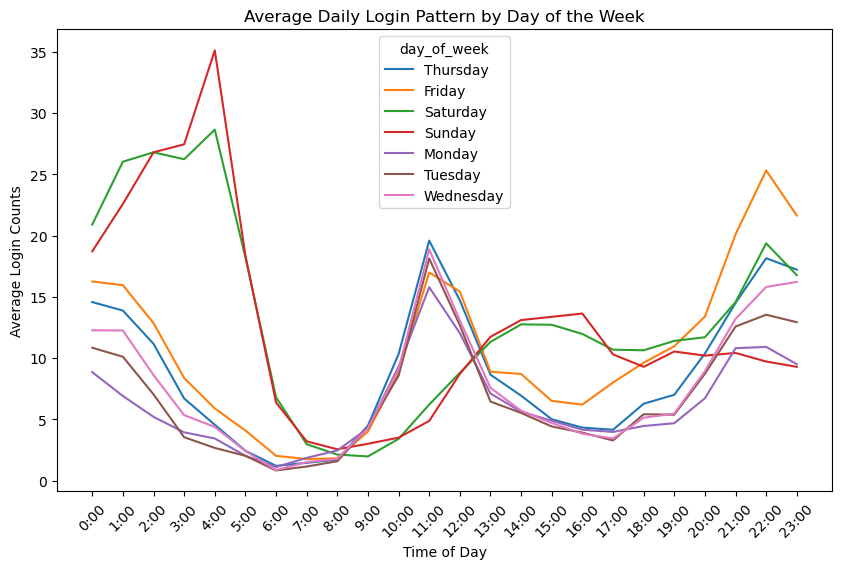

In [14]:
# Adding a new column for the day of the week
data_15min['day_of_week'] = data_15min.index.day_name()

# Plotting the data using Seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(x='hour', y='count', hue='day_of_week', data=data_15min, errorbar=None)
plt.xlabel('Time of Day')
plt.ylabel('Average Login Counts')
plt.title('Average Daily Login Pattern by Day of the Week')
plt.xticks(ticks=range(24), labels=[f'{hour}:00' for hour in range(24)], rotation=45)
plt.show();


Plotting each day of the week as a function of time shows us that the weekday login activity is fairly similar from way day to the next, especially during business hours, where they all peak around 11 am. There is some variation at the beginning of the day, and more at the end of the day. The weekend (Saturday & Sunday) login trends follow a different pattern, with the highest peaks of all the data occuring around 4 am, dipping around 7 am, and increasing throughout the day. It should also be noted that Sunday has the lowest evening login rate of all the days. 

## 3.4 Conclusions <a id='3.4'></a>

Login rates increase throughout the year, peaking in mid March. Daily login times are dependent on the days of the week, as users login at different times on weekends and weekends. Saturdays are the day of the week with the most logins on average, although the weekly peak with the most logins at once occurs on Sunday mornings around 4 am. 

The only noted data quality issue is that the dates are from 1970, which is highly unlikely to be when the logins occurred. 

# 4 Part 2 ‐ Experiment and metrics design <a id='4'></a>
The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on
weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active
during the day. On weekends, there is reasonable activity in both cities.
However, a toll bridge, with a two way toll, between the two cities causes driver partners to tend
to be exclusive to each city. The Ultimate managers of city operations for the two cities have
proposed an experiment to encourage driver partners to be available in both cities, by
reimbursing all toll costs.
1) What would you choose as the key measure of success of this experiment in
encouraging driver partners to serve both cities, and why would you choose this metric?

2) Describe a practical experiment you would design to compare the effectiveness of the
proposed change in relation to the key measure of success. Please provide details on:

a) how you will implement the experiment

b) what statistical test(s) you will conduct to verify the significance of the
observation

c) how you would interpret the results and provide recommendations to the city
operations team along with any caveats.

Note: The two cities of Gotham and Metropolis are not in the provided dataset; however, you do
not need this information to answer Part 2.

### Answers

1) The key measure of success will be if the number of trips across the toll bridge increases. As other factors won't be changing, if the number of total trips increases, these can likely be accounted to the reimbursed drivers. 

2) Practical Experiment Design:

a) I would first collect control data about how many cars crossed the toll bridge over a certain amount of time (longer is better, but a period of a month may suffice). Then the reimbursement program would need to be implemented; this includes letting drivers know that the program will be starting, and then running it for a certain amount of time, ideally for the same amount of time as the control time period. 
   
b) Statistical tests: I would first check to see if the data is normally distributed, and if the variance of the two groups is equal. If normally distributed with equal variance, I would perform a t-test; if tracking the same drivers in the control and groups over comparable times (such as weekday to weekday), I would do a paired sample t-test, and otherwise I would do an independent samples t-test. 
    
If the data is not normally distributed and can be paired, I would do a Wilcoxon Signed-Rank Test, and otherwise a Mann-Whitney U Test.
      
c) Interpretation/recommendations: For all of the above statistical tests, if the p-value is < 0.05, the results would be considered statistically significant, meaning that the pilot program does increase the number of trips across the toll bridge. If the benefits of increasing traffic between the two cities outweigh the financial burdon of the toll reimbursement program, I would recommend implenting the program. Caveats to consider: My proposed test did not take into account major events in either city, the time of year, holidays, stock market activity, how the program is advertised, or multiple possible pricing structures. I would recommend picking 2 months for this test-run (one month for collecting control data, one month for collecting test data) during a time of year without major holidays or unusually large events. 

# 5 Part 3 ‐ Predictive modeling <a id='5'></a>

Ultimate is interested in predicting rider retention. To help explore this question, we have
provided a sample dataset of a cohort of users who signed up for an Ultimate account in
January 2014. The data was pulled several months later; we consider a user retained if they
were “active” (i.e. took a trip) in the preceding 30 days.

We would like you to use this data set to help understand what factors are the best predictors
for retention, and offer suggestions to operationalize those insights to help Ultimate.
The data is in the attached file ultimate_data_challenge.json. See below for a detailed
description of the dataset. Please include any code you wrote for the analysis and delete the
dataset when you have finished with the challenge.

1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided
data for this analysis (a few sentences/plots describing your approach will suffice). What
fraction of the observed users were retained?

2. Build a predictive model to help Ultimate determine whether or not a user will be active in
their 6th month on the system. Discuss why you chose your approach, what alternatives
you considered, and any concerns you have. How valid is your model? Include any key
indicators of model performance.

3. Briefly discuss how Ultimate might leverage the insights gained from the model to
improve its long term rider retention (again, a few sentences will suffice).


## 5.1 Cleaning, EDA, Visualizations <a id='5'></a>

### 5.1a Cleaning <a id='5.1a'></a>

In [15]:
# Import the data

ultimate_data = pd.read_json(r"C:\Users\leann\OneDrive\Desktop\SPRINGBOARD\interview prep\ultimate_challenge\ultimate_data_challenge.json")

In [16]:
# Inspect the data

ultimate_data.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [17]:
ultimate_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


There are 50000 rows and 12 columns. I see some inconsistencies in data types that need to be address, as well as 3 columns (avg_rating_of_driver, phone, avg_rating_by_driver) with some null values. 

In [18]:
# Fixing data types so that the datese are in datetime format

ultimate_data['signup_date'] = pd.to_datetime(ultimate_data['signup_date'])
ultimate_data['last_trip_date'] = pd.to_datetime(ultimate_data['last_trip_date'])

In [19]:
# Deal with null values

print('Number of NAN values for Average Rating of Driver: ',ultimate_data['avg_rating_of_driver'].isna().sum())
print('Number of NAN values for Phone: ',ultimate_data['phone'].isna().sum())
print('Number of NAN values for Average Rating by Driver: ',ultimate_data['avg_rating_by_driver'].isna().sum())

Number of NAN values for Average Rating of Driver:  8122
Number of NAN values for Phone:  396
Number of NAN values for Average Rating by Driver:  201


In [20]:
# Look at average ratings of driver, we know there are 8122 NANs.
ultimate_data['avg_rating_of_driver'].describe()

count    41878.000000
mean         4.601559
std          0.617338
min          1.000000
25%          4.300000
50%          4.900000
75%          5.000000
max          5.000000
Name: avg_rating_of_driver, dtype: float64

In [21]:
# Impute using the median
ultimate_data['avg_rating_of_driver'] = ultimate_data['avg_rating_of_driver'].fillna(ultimate_data['avg_rating_of_driver'].median())


In [22]:
# Look at average ratings by driver, we know there are 201 NANs.
ultimate_data['avg_rating_by_driver'].describe()

count    49799.000000
mean         4.778158
std          0.446652
min          1.000000
25%          4.700000
50%          5.000000
75%          5.000000
max          5.000000
Name: avg_rating_by_driver, dtype: float64

In [23]:
# Impute using the median
ultimate_data['avg_rating_by_driver'] = ultimate_data['avg_rating_by_driver'].fillna(ultimate_data['avg_rating_by_driver'].median())


In [24]:
# Look at phone

ultimate_data['phone'].unique()

array(['iPhone', 'Android', None], dtype=object)

In [25]:
# Change None to 'Unknown'
ultimate_data['phone'] = ultimate_data['phone'].fillna('Unknown')

# Change phone datatype to categorical
ultimate_data['phone'] = ultimate_data['phone'].astype('category')

In [26]:
# Change city datatype to categorial

ultimate_data['city']=ultimate_data['city'].astype('category')

# change ultimate_black_user from bool to binary

ultimate_data['ultimate_black_user']= ultimate_data['ultimate_black_user'].astype('int')

In [27]:
# Double check our dataframe to make sure everything looks good now.

ultimate_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    50000 non-null  category      
 1   trips_in_first_30_days  50000 non-null  int64         
 2   signup_date             50000 non-null  datetime64[ns]
 3   avg_rating_of_driver    50000 non-null  float64       
 4   avg_surge               50000 non-null  float64       
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   50000 non-null  category      
 7   surge_pct               50000 non-null  float64       
 8   ultimate_black_user     50000 non-null  int32         
 9   weekday_pct             50000 non-null  float64       
 10  avg_dist                50000 non-null  float64       
 11  avg_rating_by_driver    50000 non-null  float64       
dtypes: category(2), datetime64[ns](2), float64(6),

In [28]:
ultimate_data.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,1,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,0,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,0,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,1,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,0,82.4,3.13,4.9


## 5.1b EDA <a id='5.1b'></a>

In this section dedicated to exploratory data analysis, I will look at time series plots of the signup dates and the last ride taken, and from there calculate the fraction of users retained. I will also look at the distribution of trips taken on weekdays, and see how retention rates are related to average ratings by and of drivers.  

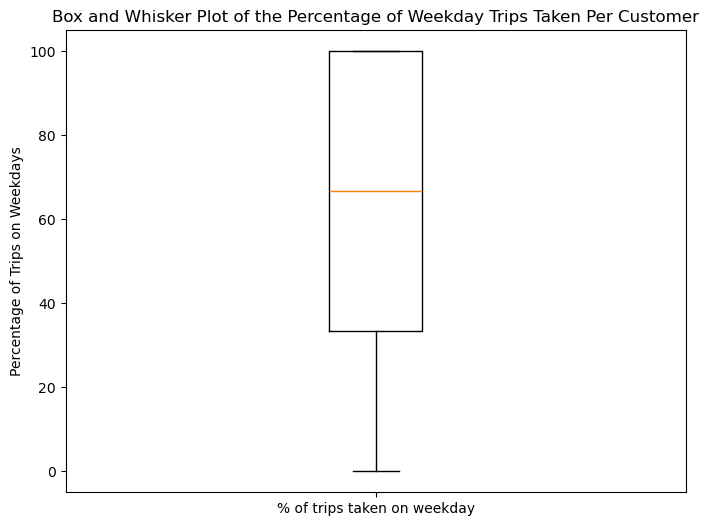

In [29]:
# Visualize the percentage of trips taken on weekdays

plt.figure(figsize=(8, 6))  # You can adjust the figure size as needed
plt.boxplot(ultimate_data['weekday_pct'])
plt.title('Box and Whisker Plot of the Percentage of Weekday Trips Taken Per Customer')
plt.ylabel('Percentage of Trips on Weekdays')
plt.xticks([1], ['% of trips taken on weekday']) 
plt.show()

Above we can see that there are a lot of weekday users. 

What  fraction of users were retained?

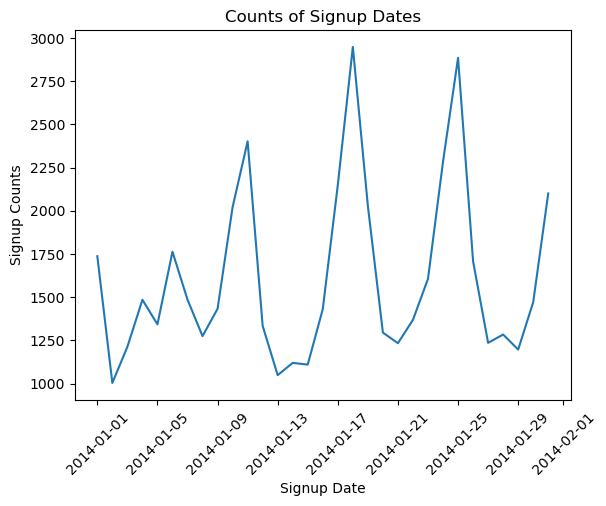

In [30]:
# First look at the signup dates and last trip dates

signup_counts = ultimate_data.groupby('signup_date').size()

plt.plot(signup_counts.index, signup_counts.values)
plt.xticks(rotation=45)
plt.xlabel('Signup Date')
plt.ylabel('Signup Counts')
plt.title('Counts of Signup Dates')

plt.show()

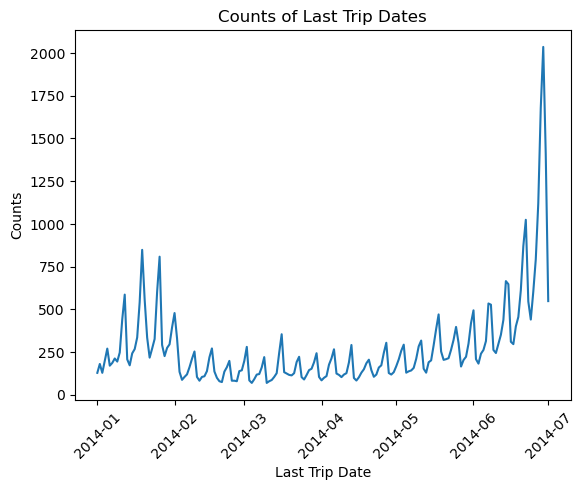

In [31]:
last_trip_counts = ultimate_data.groupby('last_trip_date').size()

plt.plot(last_trip_counts.index, last_trip_counts.values)
plt.xticks(rotation=45)
plt.xlabel('Last Trip Date')
plt.ylabel('Counts')
plt.title('Counts of Last Trip Dates')

plt.show()

In [32]:
# Now find out how many users took a trip in the final 30 days.

# Last trip date, to base the end of the 30 days we are looking at.
last_day_retained=ultimate_data['last_trip_date'].max()
last_day_retained

Timestamp('2014-07-01 00:00:00')

In [33]:
# Subtract 29 from this date to find the time frame in which we want to look 

first_day_retained = ultimate_data['last_trip_date'].max() - timedelta(days=29)
first_day_retained

Timestamp('2014-06-02 00:00:00')

In [34]:
mask = ultimate_data['last_trip_date'] >= first_day_retained
retained_count = mask.sum()

total_customer_count = len(ultimate_data.index)
print('Customers Retained: ', retained_count)
print('Fraction of Customers Retained: ', retained_count/total_customer_count)

Customers Retained:  18310
Fraction of Customers Retained:  0.3662


Now check out how customer retention is related to other factors

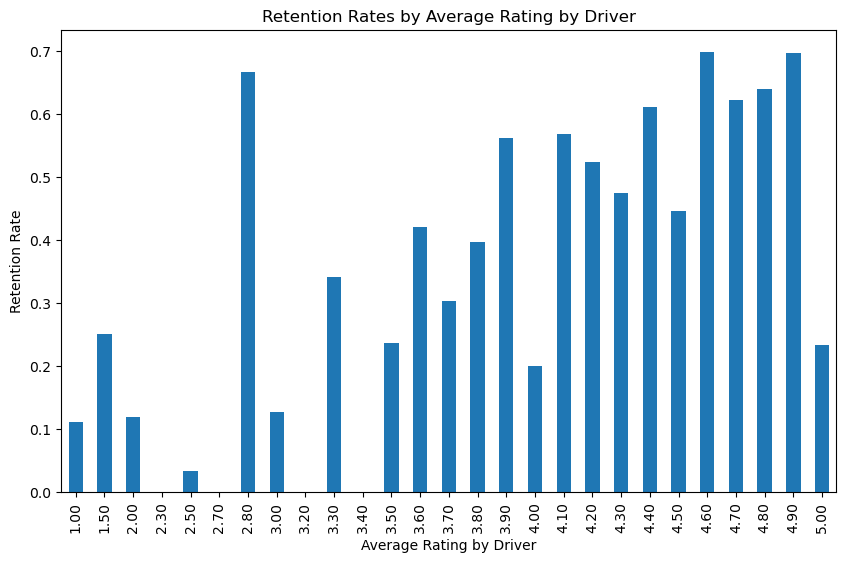

In [35]:
# Add the previously created mask as a column 
ultimate_data['is_retained'] = mask

# Look at Average Rating of Driver First:

# Group by ratings and calculate the mean of 'is_retained'
retention_rates_of_driver_rating = ultimate_data.groupby('avg_rating_of_driver')['is_retained'].mean()
retention_rates_by_driver_rating = ultimate_data.groupby('avg_rating_by_driver')['is_retained'].mean()

# Plot
plt.figure(figsize=(10, 6))
ax = retention_rates_by_driver_rating.plot(kind='bar') 
plt.title('Retention Rates by Average Rating by Driver')
plt.xlabel('Average Rating by Driver')
plt.ylabel('Retention Rate')

# Round the x-axis labels
ax.set_xticklabels([f'{rate:.2f}' for rate in retention_rates_by_driver_rating.index])

plt.show()

In [36]:
# Also check out the counts of different ratings:
driver_count_by_rating = ultimate_data.groupby('avg_rating_of_driver').size()
driver_count_by_rating

avg_rating_of_driver
1.0      256
1.5        4
1.6        1
1.7        2
1.8        2
1.9        1
2.0      209
2.1        6
2.2        1
2.3       22
2.4        3
2.5       94
2.6       12
2.7       47
2.8       28
2.9       13
3.0     1003
3.1       39
3.2       53
3.3      201
3.4      108
3.5      488
3.6      172
3.7      364
3.8      428
3.9      255
4.0     4193
4.1      398
4.2      601
4.3     1487
4.4      829
4.5     2498
4.6     1143
4.7     1945
4.8     2430
4.9     9893
5.0    20771
dtype: int64

While in the bar plot above there is a peak of retention at 2.8, there are only 28 users in this category, so I will disregard this. Overall, the trend is for retention rates to increase as the rating by driver increases. However, the whole numbers (3,4,5) all have lower retention rates than the surrounding ratings, which is curious and unexpected.

<b>Repeat the above analysis, but for Average Rating of Driver</b>

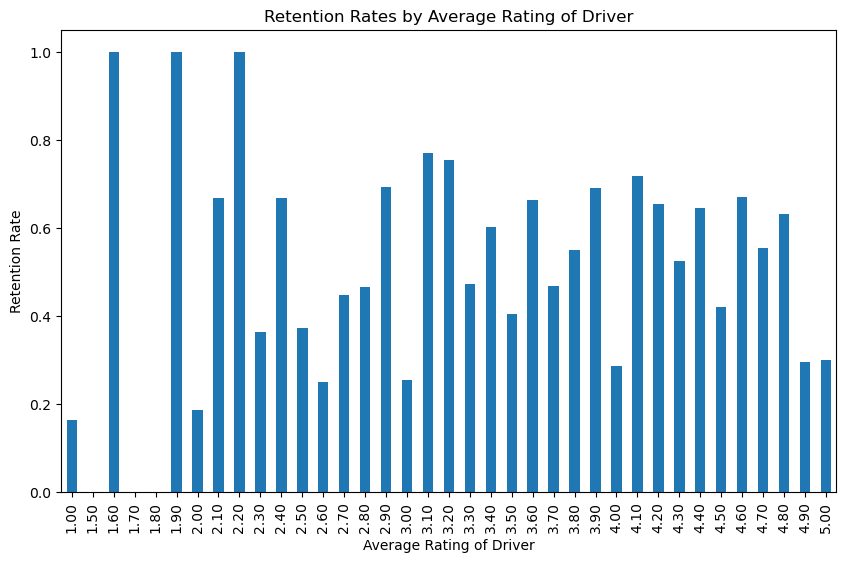

In [37]:
plt.figure(figsize=(10, 6))
ax = retention_rates_of_driver_rating.plot(kind='bar') 
plt.title('Retention Rates by Average Rating of Driver')
plt.xlabel('Average Rating of Driver')
plt.ylabel('Retention Rate')
ax.set_xticklabels([f'{rate:.2f}' for rate in retention_rates_of_driver_rating.index])

plt.show()

As with the previous plot, relatively few riders are giving low ratings to drivers, so although there are peaks I will disregard them. In this plot, the rating of the driver doesn't show a clear relationship with retention. Additionally, the whole number averages are lower than most of the values around them, which is curious, and I wonder if there are data integrity issues. I also suspect that many people simply don't like to give whole number ratings.

<b>Conclusions:</b>

The overall user retention rate is 36.62%. Generally, as the ratings given by drivers increase, the retention rates increase.

## 5.1c Modeling <a id='5.1c'></a>
In this section, I will create a predictive model to determine whether or not a user will be active in their 6th month in the system.

In [38]:
ultimate_data.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,is_retained
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,1,46.2,3.67,5.0,True
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,0,50.0,8.26,5.0,False
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,0,100.0,0.77,5.0,False
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,1,80.0,2.36,4.9,True
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,0,82.4,3.13,4.9,False


In [39]:
print('Max date of last trip: ',ultimate_data.last_trip_date.max())
print('Last signup date: ', ultimate_data.signup_date.max())

Max date of last trip:  2014-07-01 00:00:00
Last signup date:  2014-01-31 00:00:00


Because all the signups were in January and the data was tracked through July 1, all of the users have a 6 month window that we can look at, and it's not necessary to filter out users who cannot be tracked for 6 months.

Next I will create a new binary feature 'active_user' that is 1 if the user took a trip from June 1- July 1, and 0 if not.

In [40]:
ultimate_data['active_user'] = np.where(ultimate_data['last_trip_date'] >= '2014-06-01', 1, 0)

In [41]:
# The 'is_retained' column  I created earlier is similar, but I will drop it and use the new  column.
# Also dropping the signup and last trip date columns because I don't need them anymore. 

ultimate_data = ultimate_data.drop(columns = ['is_retained','signup_date','last_trip_date'], axis=1)

In [42]:
ultimate_data.head()

,city,trips_in_first_30_days,avg_rating_of_driver,avg_surge,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active_user
0,King's Landing,4,4.7,1.10,iPhone,15.4,1,46.2,3.67,5.0,1
1,Astapor,0,5.0,1.00,Android,0.0,0,50.0,8.26,5.0,0
2,Astapor,3,4.3,1.00,iPhone,0.0,0,100.0,0.77,5.0,0
3,King's Landing,9,4.6,1.14,iPhone,20.0,1,80.0,2.36,4.9,1
4,Winterfell,14,4.4,1.19,Android,11.8,0,82.4,3.13,4.9,0


In [43]:
# Do one-hot-encoding on the categorical features
encoded_data = pd.DataFrame()

for col in ultimate_data.columns:
    if ultimate_data[col].dtype == 'category':
        encoded_data = pd.concat([encoded_data, pd.get_dummies(ultimate_data[col], prefix=col)], axis=1)
    else:
        encoded_data = pd.concat([encoded_data,ultimate_data[[col]]], axis=1)

# Convert bool to binary
for col in encoded_data.columns:
    if encoded_data[col].dtype == bool:
        encoded_data[col] = encoded_data[col].astype(int)


In [44]:
# Scale the continous features

scaler = StandardScaler()

continuous_features = ['avg_rating_of_driver', 'trips_in_first_30_days', 'surge_pct', 'weekday_pct', 'avg_dist', 'avg_rating_by_driver']

scaled_data = scaler.fit_transform(encoded_data[continuous_features])

scaled_data = pd.DataFrame(scaled_data, columns=continuous_features, index=encoded_data.index)

encoded_data[continuous_features] = scaled_data

In [45]:
encoded_data.head()

,city_Astapor,city_King's Landing,city_Winterfell,trips_in_first_30_days,avg_rating_of_driver,avg_surge,phone_Android,phone_Unknown,phone_iPhone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active_user
0,0,1,0,0.453984,0.086801,1.10,0,0,1,0.328202,1,-0.397131,-0.372650,0.495437,1
1,1,0,0,-0.600689,0.608000,1.00,1,0,0,-0.443394,0,-0.294653,0.431583,0.495437,0
2,1,0,0,0.190316,-0.608132,1.00,0,0,1,-0.443394,0,1.053741,-0.880771,0.495437,0
3,0,1,0,1.772325,-0.086933,1.14,0,0,1,0.558679,1,0.514383,-0.602181,0.271207,1
4,0,0,1,3.090665,-0.434399,1.19,1,0,0,0.147829,0,0.579106,-0.467266,0.271207,0


### Train Test Split

In [46]:
X = encoded_data.drop('active_user', axis=1)
y = encoded_data['active_user']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Logistic Regression Baseline Model
I am starting with logistic regression because it is straightford and fast to implement, and it is often a good choice when dealing with a binary target variable.

In [47]:
log_reg = LogisticRegression()

log_reg.fit(X_train, y_train)

y_pred = log_reg.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
scores = cross_val_score(log_reg, X, y, cv=5, scoring='recall') 
print("Mean Recall CV Score: ", scores.mean())
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.7171
Mean Recall CV Score:  0.49457593894788054

Confusion Matrix:
 [[5267  952]
 [1877 1904]]

Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.85      0.79      6219
           1       0.67      0.50      0.57      3781

    accuracy                           0.72     10000
   macro avg       0.70      0.68      0.68     10000
weighted avg       0.71      0.72      0.71     10000



These metrics aren't great, especially positive class recall and F1 score. I will now do some hyperparameter tuning.

In [48]:
param_grid = {
    'C': uniform(loc=0, scale=4),
    'penalty': ['l1', 'l2'],  
    'solver': ['saga', 'liblinear']
}

log_reg_tuned = LogisticRegression(max_iter=1000)  

random_search = RandomizedSearchCV(log_reg_tuned, param_distributions=param_grid, n_iter=100, cv=5, verbose=2, random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)

print("Best parameters found: ", random_search.best_params_)
y_pred_tuned = random_search.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred_tuned))
print("Recall:", recall_score(y_test, y_pred_tuned))


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters found:  {'C': 0.022088468494409597, 'penalty': 'l1', 'solver': 'saga'}
Accuracy: 0.7173
Recall: 0.49880983866701933


In [49]:
scores = cross_val_score(log_reg_tuned, X, y, cv=5, scoring='recall') 
print("Mean Recall CV Score: ", scores.mean())

print(classification_report(y_test, y_pred_tuned))

Mean Recall CV Score:  0.49457593894788054
              precision    recall  f1-score   support

           0       0.74      0.85      0.79      6219
           1       0.67      0.50      0.57      3781

    accuracy                           0.72     10000
   macro avg       0.70      0.67      0.68     10000
weighted avg       0.71      0.72      0.71     10000



Tuning didn't actually help at all. 

Moving on to an XGBoost Classification model now. 

### XGBoost Classification Model

In [50]:
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_clf.fit(X_train, y_train)
y_pred_xgb = xgb_clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
scores = cross_val_score(xgb_clf, X, y, cv=5, scoring='recall') 
print("Mean Recall CV Score: ", scores.mean())
print("\nClassification Report:\n", classification_report(y_test, y_pred_xgb))


Accuracy: 0.7868
Mean Recall CV Score:  0.6685286280810332

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.85      0.83      6219
           1       0.74      0.68      0.71      3781

    accuracy                           0.79     10000
   macro avg       0.78      0.77      0.77     10000
weighted avg       0.78      0.79      0.78     10000



This model is much better! I will now do some hyperparameter tuning to see if I can further improve it.

In [51]:
parameters = {
    'max_depth': [3, 5, 7],
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2]
}

grid_search = GridSearchCV(estimator=xgb_clf, param_grid=parameters, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)
xgb_clf_tuned = grid_search.best_estimator_

print("Best Parameters:", grid_search.best_params_)


Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}


In [52]:
# make predictions
y_pred_xbg_tuned = xgb_clf_tuned.predict(X_test)

# metrics
print("Accuracy:", accuracy_score(y_test, y_pred_xbg_tuned))
scores = cross_val_score(xgb_clf_tuned, X, y, cv=5, scoring='recall') 
print("Mean Recall CV Score: ", scores.mean())
print("\nClassification Report:\n", classification_report(y_test, y_pred_xbg_tuned))


Accuracy: 0.7893
Mean Recall CV Score:  0.6740592701126341

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.86      0.83      6219
           1       0.74      0.68      0.71      3781

    accuracy                           0.79     10000
   macro avg       0.78      0.77      0.77     10000
weighted avg       0.79      0.79      0.79     10000



The tuning didn't help much, but it did help a little. The mean cv recall score and the classification report recall score are almost identical, which indicates minimal overfitting and this model should generalize to new data well. 

### Model Selection

The best model of those tested is xgb_clf_tuned. It correctly predicts if a user will take a trip in their 6th month after signing up 68% of the time, and correctly predicts which users will be inactive 86% of th time, with an overall accuracy score of 0.79. 

### SHAP Analysis
I will now proceed with SHAP analysis on my model, so that I can determine which features contribute towards users being active after 6 months. 

In [53]:
# First build model on all of the data

best_params = grid_search.best_params_

xgb_model_full = xgb.XGBClassifier(**best_params, use_label_encoder=False, eval_metric='logloss')

xgb_model_full.fit(X, y)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

[13:48:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


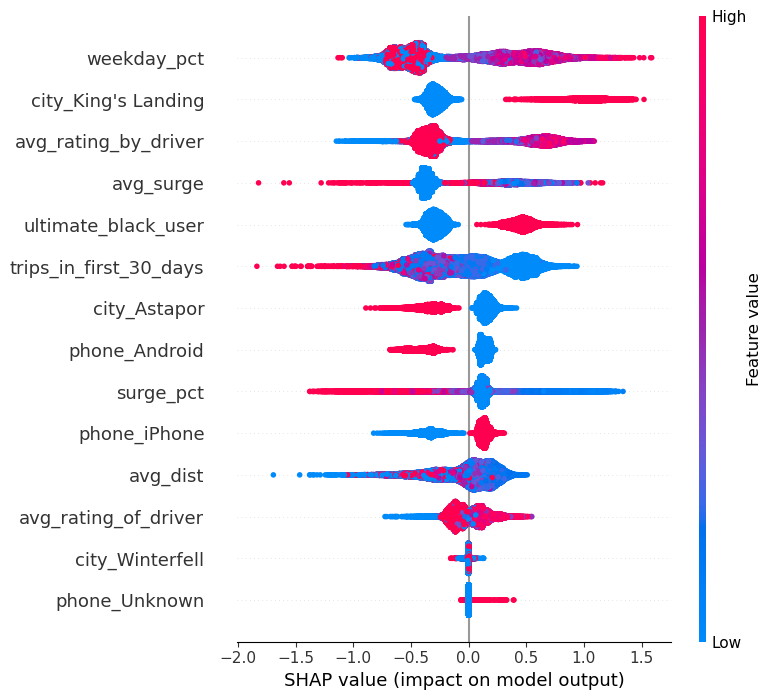

In [54]:
# Create SHAP explainer

explainer = shap.Explainer(xgb_model_full)
shap_values = explainer(X)
shap.summary_plot(shap_values, X)


<b> SHAP Discussion: </b>

There are some very clear results here! 

<i>The following features contribute towards users being active after 6 months:</i>
* City of King's Landing
* Ultimate Black user
* iPhone users
* Higher Driver ratings (Note: The higher feature values also cross over into negative SHAP values)
* Unknown phone (Note: the unknown phone users cross slightly into negative SHAP values)

<i> The following features contribute towards users being inactive after 6 months: </i>
* Top 50% of trips taken in the first 30 days
* City of Astapor
* Android users
* Surge percentage in the top 50%

### Modeling Discussion

In this section, I built a model to predict if a user will be active in their 6th month on the system. I tried two models, logistic regression as my baseline model, and then XGBoost. I first tried logistic regression because it is straightforward, easy to implement, works well for a binary target, and provides probability of outcomes. However, there is an assumption in logistic regression that the log odds are linear, and I am not sure if this is the case or not. I then tried XGBoost Classifier as my next model because it does a great job at handling complex relationships, works well with binary targets and minimizes overfitting. 

The logistic regression model did not perform very well, with a recall score of the positive class of 0.50. However, it did a much better job at predicting the negative class recall, with a score of 0.85. I wanted to see if I could build a better model, so I then moved on to XGBoost.

The XGBoost Classififier model performed better. It had a recall score of the positive class of 0.68, and a recall score of the negative class of 0.86, and there does not appear to be overfitting. This model does a much better job predicting customers that will be inactive after 6 months, but still does a reasonably good job of predicting active users. 

After developing the tuned XGBoost model, I performed SHAP analysis to determine the factors that are the best predictors of retention. These factors that contribute most strongly to user retention are city of King's Landing, Ultimate Black users, and iPhone users. Higher driver ratings and unknown phone are mostly associated with higher contributions towards user retention, but there's a less clear relationship here. 

# 6 Recommendations <a id='6'></a>

Based upon my modeling and SHAP analysis, I would recommend increasing marketing efforts towards certain groups of users. In particular, focusing on users in the city of King's Landing, and less in Astapor would likely increase long term users. Additionally, directing marketing efforts towards iPhone, known Ultimate Black users, and users who give their drivers better ratings would likely yield improved user retention. 